In [3]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

from utils.process import categorize
from utils.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Import dataset

In [4]:
# See working directory (No need, just for myself)
os.getcwd()

'/Users/stevenr/Documents/Cours_MD5/projet_data/9mai/data_project-master'

In [5]:
df = pd.read_csv('./data_cars.csv')

In [6]:
df.head(10)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."
5,27956.0,BMW,X3,2012,95623.0 km,Diesel,automatique,14/03/2018 à 4h24,"modele: X3 F25, version: (F25) XDRIVE35D 313 S..."
6,16888.0,AUDI,A3,2013,49018.0 km,Diesel,mécanique,16/04/2018 à 21h35,"modele: A3 (2E GENERATION) SPORTBACK, version:..."
7,18188.0,RENAULT,MEGANE,2017,9795.0 km,Diesel,automatique,29/04/2018 à 12h44,"modele: MEGANE 4 ESTATE, version: IV ESTATE 1...."
8,10594.0,FORD,C-MAX,2012,126670.0 km,Diesel,mécanique,22/06/2018 à 5h11,"modele: C-MAX 2, version: II 1.6 TDCI 115 FAP ..."
9,69131.0,MERCEDES,CLASSE C,2015,39439.0 km,Essence,automatique,08/03/2018 à 17h35,"modele: CLASSE C 4 AMG, version: (W205) 63 AMG..."


## Observations

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

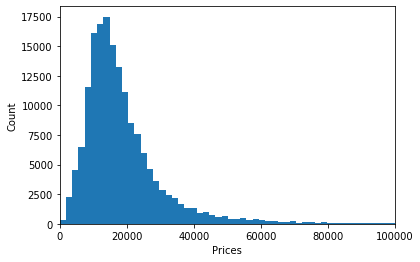

In [8]:
# Price repartition
plt.hist(df["Price"], 800)
plt.xlim(0, 100000)
plt.xlabel('Prices')
plt.ylabel('Count')
plt.show()

Les prix semblent s'agglutiner entre 20000 et 25000 €

In [9]:
# relation between mileage and price
#plt.hist(df['Mileage'],df['Price'])
#plt.xlim(0, 100000)
#plt.xlabel("Mileage")
#plt.ylabel("Price")
#plt.xlim(0, 90000)

Text(0, 0.5, 'Number of cars')

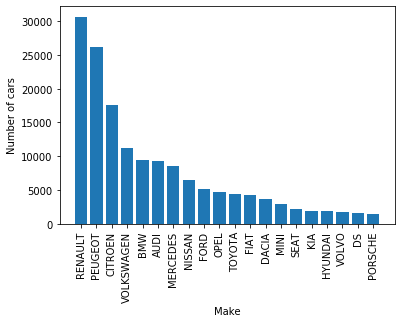

In [10]:
# Make cars counts
counts = df["Make"].value_counts().iloc[0:20]
names = counts.keys().to_numpy()
values = counts.to_numpy()

plt.bar(names, values)
plt.xticks(rotation="vertical")
plt.xlabel("Make")
plt.ylabel("Number of cars")

Le dataset contient beaucoup de voitures Renault, Peugeot et Citroen que de voitures de marque étrangère (BMW, Ford, Mercedes)

## Some data cleaning

### Data Modification

In [11]:
# Getting the number of doors on the car
import re
df['Nbre_porte'] = df['Description'].str.extract("portes: (.)")

In [12]:
# Getting the horse power of a car
df['CV'] = df['Description'].str.extract("puissance_fiscale: (..)")
df['CV'] = df['CV'].str.replace(',', '')

In [13]:
# We choose 2018 because it was the year the sellers published their offers
df['Model_year'] = df.apply(lambda row: 2018 - row.Model_year, axis = 1)
#df.head()

### Data checks

In [14]:
# Check for null values
df.isnull().sum()

Price          0
Make           0
Model          0
Model_year     0
Mileage        0
Fuel           0
Gearbox        0
Online         0
Description    0
Nbre_porte     0
CV             0
dtype: int64

In [15]:
# Check for invalid numbers
df.isna().sum()

Price          0
Make           0
Model          0
Model_year     0
Mileage        0
Fuel           0
Gearbox        0
Online         0
Description    0
Nbre_porte     0
CV             0
dtype: int64

In [16]:
# Find empty strings
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

### Data types conversions

In [17]:
## Remove kilometers and convert to number
df["Mileage"] = df["Mileage"].str.replace(' km', '').astype("float64")
df.head(5)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description,Nbre_porte,CV
0,11220.0,PEUGEOT,308,4,94341.0,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",5,4
1,57526.0,BMW,X6,3,39051.0,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",5,16
2,80379.0,AUDI,RS6,4,75381.0,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",5,47
3,2830.0,FORD,KA,11,92282.0,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",3,5
4,12925.0,FIAT,TIPO,0,10.0,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",5,5


In [18]:
df.dtypes['Mileage']

dtype('float64')

In [19]:
df["Mileage"].isna().sum()

0

In [20]:
# Reduce allocated bytes size for "Model_year" 
df["Model_year"] = df["Model_year"].astype("int16")

In [21]:
# We don't really need the "Online" column as it seems to indicate the last user authentication
df = df.drop("Online", axis=1)
df = df.drop("Description", axis=1)

In [22]:
# This will delete 1000 rows so it not might be the best method
indexNames = df[(df['Nbre_porte'] == ',')].index
df.drop(indexNames , inplace=True)
df['Nbre_porte'] = df['Nbre_porte'].astype(str).astype(int)

In [23]:
df['CV'] = df['CV'].astype(int)

In [25]:
df1 =df

### Hot encoding

In [26]:
# List categorical columns
df["Fuel"].unique()

array(['Diesel', 'Essence', 'Hybride essence électrique', 'Electrique',
       'Hybride diesel électrique', 'Bicarburation essence GPL',
       'Bicarburation essence bioéthanol'], dtype=object)

In [27]:
# List categorical columns for Gearbox
df["Gearbox"].unique()

array(['mécanique', 'automatique'], dtype=object)

In [28]:
df = pd.get_dummies(df, columns=["Gearbox"], drop_first=True)

In [29]:
# List categorical columns
df = pd.get_dummies(df, columns=["Fuel"])

In [30]:
df.head(5)

,Price,Make,Model,Model_year,Mileage,Nbre_porte,CV,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,PEUGEOT,308,4,94341.0,5,4,1,0,0,1,0,0,0,0
1,57526.0,BMW,X6,3,39051.0,5,16,0,0,0,1,0,0,0,0
2,80379.0,AUDI,RS6,4,75381.0,5,47,0,0,0,0,0,1,0,0
3,2830.0,FORD,KA,11,92282.0,3,5,1,0,0,0,0,1,0,0
4,12925.0,FIAT,TIPO,0,10.0,5,5,1,0,0,0,0,1,0,0


In [31]:
np.sort(df['Make'].unique())

array(['ABARTH', 'AC', 'AIXAM', 'ALFA ROMEO', 'ALPINA', 'ALPINE',
       'ASTON MARTIN', 'AUDI', 'AUSTIN', 'AUSTIN HEALEY', 'AUTOBIANCHI',
       'BELLIER', 'BENTLEY', 'BMW', 'BMW-ALPINA', 'BOLLORE', 'BUGATTI',
       'CADILLAC', 'CHATENET', 'CHEVROLET', 'CHRYSLER', 'CITROEN',
       'DACIA', 'DAEWOO', 'DAIHATSU', 'DANGEL', 'DODGE', 'DONKERVOORT',
       'DS', 'FERRARI', 'FIAT', 'FISKER', 'FORD', 'GRECAV', 'HONDA',
       'HUMMER', 'HYUNDAI', 'INFINITI', 'INNOCENTI', 'INTERMECCANICA',
       'JAGUAR', 'JEEP', 'JIAYUAN', 'KIA', 'LADA', 'LAMBORGHINI',
       'LANCIA', 'LAND ROVER', 'LEXUS', 'LIGIER', 'LOTUS', 'MASERATI',
       'MATRA', 'MAZDA', 'MCLAREN', 'MERCEDES', 'MERCEDES-AMG', 'MG',
       'MICROCAR', 'MINI', 'MITSUBISHI', 'MORGAN', 'MPM MOTORS', 'NISSAN',
       'OLDSMOBILE', 'OPEL', 'PACKARD', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'RILEY', 'ROLLS ROYCE', 'ROVER', 'SAAB', 'SEAT', 'SHELBY', 'SIMCA',
       'SKODA', 'SMART', 'SSANGYONG', 'SUBARU', 'SUNBEAM', 'SUZUKI',
       'TES

In [32]:
# Transform makes to ordinal numbers
df['Make'] = categorize(df['Make'])
df['Make'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: Make, dtype: int8

In [33]:
np.sort(df['Model'].unique()[0:60])

array(['2008', '208', '3008', '308', '407', '500', '500 X', '5008', 'A3',
       'A4', 'A5', 'ARONA', 'ASTRA', 'AURIS', 'C-MAX', 'C3', 'C4',
       'C4 PICASSO', 'C5', 'CLASSE A', 'CLASSE B', 'CLASSE C', 'CLASSE R',
       'CLIO', 'DS3', 'DUSTER', 'GOLF', 'GRAND C-MAX',
       'GRAND C4 SPACETOURER', 'GRAND SCENIC', 'I20', 'I30', 'IBIZA',
       'KA', 'KADJAR', 'KOLEOS', 'KUGA', 'MACAN', 'MEGANE', 'MINI',
       'MONDEO', 'PASSAT', 'POLO', 'QASHQAI', 'RS6', 'SANDERO', 'SCENIC',
       'SERIE 1', 'SERIE 2', 'SERIE 3 GT', 'SERIE 5', 'SL', 'TALISMAN',
       'TIGUAN', 'TIPO', 'TOURAN', 'TWINGO', 'X3', 'X6', 'XKR'],
      dtype=object)

In [34]:
# Transform models to ordinal numbers
df['Model'] = categorize(df['Model'])
df['Model'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: Model, dtype: int16

In [35]:
df.head()

,Price,Make,Model,Model_year,Mileage,Nbre_porte,CV,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,0,0,4,94341.0,5,4,1,0,0,1,0,0,0,0
1,57526.0,1,1,3,39051.0,5,16,0,0,0,1,0,0,0,0
2,80379.0,2,2,4,75381.0,5,47,0,0,0,0,0,1,0,0
3,2830.0,3,3,11,92282.0,3,5,1,0,0,0,0,1,0,0
4,12925.0,4,4,0,10.0,5,5,1,0,0,0,0,1,0,0


In [36]:
df.dtypes

Price                                    float64
Make                                        int8
Model                                      int16
Model_year                                 int16
Mileage                                  float64
Nbre_porte                                 int64
CV                                         int64
Gearbox_mécanique                          uint8
Fuel_Bicarburation essence GPL             uint8
Fuel_Bicarburation essence bioéthanol      uint8
Fuel_Diesel                                uint8
Fuel_Electrique                            uint8
Fuel_Essence                               uint8
Fuel_Hybride diesel électrique             uint8
Fuel_Hybride essence électrique            uint8
dtype: object

## Features selection

In [37]:
plt.figure(figsize=(10, 10))
corrplot(corr)

NameError: name 'corrplot' is not defined

<Figure size 720x720 with 0 Axes>

In [52]:
df1=df
df1 = (df - df.mean()) / (df.std())

Pour l'instant il n'y a que "CV" qui a un bon taux de correlation avec "Price"

## Split

In [38]:
features = [
    "Make",
    "Model", 
    "Model_year",
    "Mileage",
    "Fuel_Bicarburation essence GPL",
    "Fuel_Bicarburation essence bioéthanol",
    "Fuel_Diesel",
    "Fuel_Electrique",
    "Fuel_Essence",
    "Gearbox_mécanique",
]

prediction = "Price"

X = df[features]
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((115784, 10), (49622, 10), (115784,), (49622,))

In [40]:
X_train.head(5)

,Make,Model,Model_year,Mileage,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Gearbox_mécanique
53438,5,41,18,117174.0,0,0,0,0,1,1
77026,6,101,3,47056.0,0,0,1,0,0,0
145899,12,18,2,26171.0,0,0,1,0,0,1
137407,1,66,4,120916.0,0,0,1,0,0,0
152546,5,53,3,40780.0,0,0,1,0,0,1


In [41]:
y_train.head(5)

53438      2214.0
77026     27088.0
145899     9980.0
137407    14739.0
152546    15868.0
Name: Price, dtype: float64

## Train / Predict

In [42]:
lreg = LinearRegression()

In [43]:
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)

In [44]:
mean_squared_error(y_test, y_pred)

222820914.39324194

In [45]:
mean_absolute_percentage_error(y_test, y_pred)

151.49467880971756

In [46]:
r2_score(y_test, y_pred)

0.25652656055556833

##  Test with manual encoding and label encoding

In [47]:
make_label = {ni: n for n,ni in enumerate(set(df1['Make']))}
model_label = {ni: n for n,ni in enumerate(set(df1['Model']))}
fuel_label = {ni: n for n,ni in enumerate(set(df1['Fuel']))}
gearbox_label = {ni: n for n,ni in enumerate(set(df1['Gearbox']))}

In [48]:
fuel_label

{'Bicarburation essence GPL': 0,
 'Hybride essence électrique': 1,
 'Electrique': 2,
 'Hybride diesel électrique': 3,
 'Essence': 4,
 'Diesel': 5,
 'Bicarburation essence bioéthanol': 6}

In [49]:
df1['Fuel'].unique()

array(['Diesel', 'Essence', 'Hybride essence électrique', 'Electrique',
       'Hybride diesel électrique', 'Bicarburation essence GPL',
       'Bicarburation essence bioéthanol'], dtype=object)

In [50]:
df1['Make'].unique()

array(['PEUGEOT', 'BMW', 'AUDI', 'FORD', 'FIAT', 'RENAULT', 'MERCEDES',
       'SEAT', 'MINI', 'HYUNDAI', 'DACIA', 'VOLKSWAGEN', 'CITROEN',
       'TOYOTA', 'JAGUAR', 'OPEL', 'PORSCHE', 'NISSAN', 'LAND ROVER',
       'MAZDA', 'VOLVO', 'SKODA', 'DS', 'SSANGYONG', 'SUZUKI', 'HONDA',
       'LEXUS', 'INFINITI', 'JEEP', 'KIA', 'DODGE', 'ASTON MARTIN',
       'LANCIA', 'LOTUS', 'CHEVROLET', 'SMART', 'ALFA ROMEO', 'BUGATTI',
       'MITSUBISHI', 'MERCEDES-AMG', 'AIXAM', 'FERRARI', 'MG',
       'LAMBORGHINI', 'MASERATI', 'SUBARU', 'MORGAN', 'CHRYSLER',
       'ROLLS ROYCE', 'TESLA', 'ABARTH', 'LADA', 'BMW-ALPINA', 'SAAB',
       'PACKARD', 'ROVER', 'SHELBY', 'MICROCAR', 'ALPINA', 'BENTLEY',
       'DAIHATSU', 'HUMMER', 'TRIUMPH', 'LIGIER', 'DAEWOO',
       'AUSTIN HEALEY', 'JIAYUAN', 'CADILLAC', 'MCLAREN', 'DANGEL',
       'CHATENET', 'INTERMECCANICA', 'AC', 'AUTOBIANCHI', 'SUNBEAM',
       'BOLLORE', 'AUSTIN', 'MPM MOTORS', 'INNOCENTI', 'MATRA',
       'DONKERVOORT', 'GRECAV', 'FISKER', 'ALP

In [51]:
df1['Model'].unique()

array(['308', 'X6', 'RS6', 'KA', 'TIPO', 'X3', 'A3', 'MEGANE', 'C-MAX',
       'CLASSE C', 'IBIZA', 'MINI', '500 X', 'MONDEO', 'I20', 'SANDERO',
       '208', 'GOLF', 'C3', 'AURIS', 'I30', 'POLO', 'SERIE 1', 'XKR',
       'CLASSE B', 'CLIO', 'TOURAN', 'CLASSE R', 'TIGUAN', 'TALISMAN',
       'ASTRA', 'GRAND SCENIC', 'A4', 'DS3', '407', 'DUSTER', 'MACAN',
       'QASHQAI', 'KADJAR', 'SCENIC', 'A5', 'TWINGO', 'PASSAT', 'ARONA',
       'GRAND C-MAX', 'KUGA', 'SERIE 2', 'SL', '500', 'C4', '5008',
       '3008', 'GRAND C4 SPACETOURER', 'KOLEOS', 'CLASSE A', 'C4 PICASSO',
       '2008', 'SERIE 5', 'C5', 'SERIE 3 GT', 'C3 AIRCROSS', 'LEON',
       'TUCSON', 'RANGE ROVER EVOQUE', 'ESPACE', 'A7', 'SERIE 3',
       'ZAFIRA', '6', 'XC60', '1007', 'AVENSIS', 'OCTAVIA', 'YARIS',
       'JUKE', '508 RXH', 'V40', '108', '508', 'SERIE 4', 'DS 5',
       'CAPTUR', 'GLA', '307', 'TRAVELLER', 'CORSA', 'COCCINELLE',
       'RAV 4', 'KYRON', 'X5', 'MULTIPLA', 'S-MAX', 'SX4', 'MOKKA X',
       'X1', 'LAGUNA

In [52]:
df1['Gearbox'].unique()

array(['mécanique', 'automatique'], dtype=object)

In [53]:
print('make_label = {}'.format(make_label))
print('model_label = {}'.format(model_label))
print('fuel_label = {}'.format(fuel_label))
print('gearbox_label = {}'.format(gearbox_label))

make_label = {'HUMMER': 0, 'KIA': 1, 'CHATENET': 2, 'MICROCAR': 3, 'RENAULT': 4, 'ROLLS ROYCE': 5, 'AUSTIN': 6, 'JIAYUAN': 7, 'MASERATI': 8, 'MCLAREN': 9, 'SKODA': 10, 'ASTON MARTIN': 11, 'INTERMECCANICA': 12, 'CADILLAC': 13, 'HYUNDAI': 14, 'MERCEDES': 15, 'ALPINE': 16, 'SIMCA': 17, 'SUZUKI': 18, 'MG': 19, 'CHRYSLER': 20, 'AC': 21, 'AUTOBIANCHI': 22, 'ABARTH': 23, 'BENTLEY': 24, 'DANGEL': 25, 'LAND ROVER': 26, 'FISKER': 27, 'SHELBY': 28, 'MINI': 29, 'SUNBEAM': 30, 'PORSCHE': 31, 'SUBARU': 32, 'CHEVROLET': 33, 'PACKARD': 34, 'ALFA ROMEO': 35, 'LIGIER': 36, 'CITROEN': 37, 'NISSAN': 38, 'DODGE': 39, 'INFINITI': 40, 'SEAT': 41, 'MAZDA': 42, 'BUGATTI': 43, 'LAMBORGHINI': 44, 'FIAT': 45, 'LEXUS': 46, 'AUSTIN HEALEY': 47, 'ROVER': 48, 'JAGUAR': 49, 'DS': 50, 'DACIA': 51, 'BELLIER': 52, 'MERCEDES-AMG': 53, 'BMW-ALPINA': 54, 'DAEWOO': 55, 'VOLVO': 56, 'VOLKSWAGEN': 57, 'SSANGYONG': 58, 'BMW': 59, 'TRIUMPH': 60, 'ALPINA': 61, 'AIXAM': 62, 'PEUGEOT': 63, 'MATRA': 64, 'OPEL': 65, 'SAAB': 66, 'DONK

In [54]:
df1.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Nbre_porte,CV
0,11220.0,PEUGEOT,308,4,94341.0,Diesel,mécanique,5,4
1,57526.0,BMW,X6,3,39051.0,Diesel,automatique,5,16
2,80379.0,AUDI,RS6,4,75381.0,Essence,automatique,5,47
3,2830.0,FORD,KA,11,92282.0,Essence,mécanique,3,5
4,12925.0,FIAT,TIPO,0,10.0,Essence,mécanique,5,5


In [55]:
df1['Make'] = df1['Make'].map(make_label)
df1['Model'] = df1['Model'].map(model_label)
df1['Fuel'] = df1['Fuel'].map(fuel_label)
df1['Gearbox'] = df1['Gearbox'].map(gearbox_label)

In [57]:
df2 = (df1 - df1.mean()) / (df1.std())

In [58]:
df1.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Nbre_porte,CV
0,11220.0,63,601,4,94341.0,5,1,5,4
1,57526.0,59,640,3,39051.0,5,0,5,16
2,80379.0,71,419,4,75381.0,4,0,5,47
3,2830.0,72,161,11,92282.0,4,1,3,5
4,12925.0,45,718,0,10.0,4,1,5,5


In [59]:
df1.dtypes

Price         float64
Make            int64
Model           int64
Model_year      int16
Mileage       float64
Fuel            int64
Gearbox         int64
Nbre_porte      int64
CV              int64
dtype: object

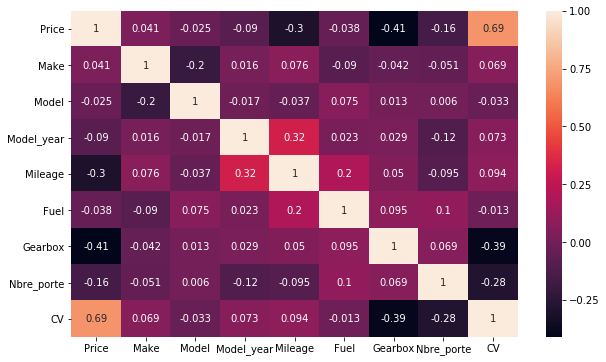

In [60]:
plt.figure(figsize=(10,6))
sns.heatmap(df1.corr(), annot=True)

In [61]:
df1.describe()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Nbre_porte,CV
count,1.654060e+05,165406.000000,165406.000000,165406.000000,1.654060e+05,165406.000000,165406.000000,165406.000000,165406.000000
mean,1.932165e+04,41.810321,441.015761,3.378656,4.675428e+04,4.594749,0.677279,4.690785,7.061207
std,1.635159e+04,24.823871,242.676161,8.298584,4.801981e+04,0.691782,0.467518,0.767870,4.735703
min,1.000000e+00,0.000000,0.000000,-3000.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.131900e+04,15.000000,189.000000,1.000000,9.159000e+03,4.000000,0.000000,5.000000,5.000000
50%,1.578200e+04,45.000000,499.000000,2.000000,3.040900e+04,5.000000,1.000000,5.000000,6.000000
75%,2.270800e+04,63.000000,634.000000,5.000000,7.311175e+04,5.000000,1.000000,5.000000,8.000000
max,1.486500e+06,87.000000,830.000000,118.000000,1.418551e+06,6.000000,1.000000,6.000000,81.000000


## X & Y 

In [62]:
Xfeatures = df1[[
    "Make",
    "Model", 
    "Model_year",
    "Mileage",
    "Fuel",
    "CV",
    "Nbre_porte",
    "Gearbox"   
]]
ylabels = df1['Price']

## Split Dataset

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(Xfeatures, ylabels, test_size=0.30, random_state=42)

In [66]:
lreg = LinearRegression()

In [67]:
lreg.fit(X_train, Y_train)
y_pred = lreg.predict(X_test)

In [68]:
mean_squared_error(Y_test, y_pred)

136248550.4193922

In [69]:
mean_absolute_percentage_error(Y_test, y_pred)

187.9901191896427

In [70]:
r2_score(Y_test, y_pred)

0.5453874755183399